# Data preparation

NeuralGCM models take and produce data on defined on [37 pressure levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels), including the following variables, provided in SI units and on the NeuralGCM model's native grid:

- Inputs/outputs (on pressure levels): `u_component_of_wind`, `v_component_of_wind`, `geopotential`, `temperature`, `specific_humidity`, `specific_cloud_ice_water_content`, `specific_cloud_liquid_water_content`.
- Forcings (surface level only): `sea_surface_temperature`, `sea_ice_cover`

## Regridding data

Preparing a dataset stored on a different horizontal grid for NeuralGCM requires two steps:

1. Horizontal regridding to a Gaussian grid. For processing fine-resolution data conservative regridding is most appropriate (and is what we used to train NeuralGCM).
2. Filling in all missing values (NaN), to ensure all inputs are valid. Forcing fields like `sea_surface_temperature` are only defined over ocean in ERA5, and NeuralGCM's surface model also includes a mask that ignores values over land, but we still need to fill all NaN values to them leaking into our model outputs.

Utilities for both of these operations are packaged as part of Dinosaur. We'll show how to use them on the Zarr copy of ERA5 from the [ARCO-ERA5](https://github.com/google-research/arco-era5) project:

In [49]:
import jax
import numpy as np
import gcsfs
import neuralgcm
import xarray

# load demo model
checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)

# create a xarray.Dataset with required variables for NeuralGCM
gcs = gcsfs.GCSFileSystem(token='anon')
path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(path), chunks=None)
full_era5 = full_era5[model.input_variables + model.forcing_variables]

In [7]:
full_era5

<xarray.Dataset>
Dimensions:                              (time: 1087704, level: 37,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 90.0 89.75 ... -90.0
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float32 0.0 0.25 ... 359.8
  * time                                 (time) datetime64[ns] 1900-01-01 ......
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 ...
    specific_humidity                    (time, level, latitude, longitude) float32 ...
    temperature                          (time, level, latitude, longitude) float32 ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 ...
    sea_ice_cover                        (time, latitude, longitude) float32 ...
    sea_surface_temperature              (time, latitude, longitude) float32 ...

Based on this dataset and our model grid, we can build a `Regridder` object:

In [26]:
from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils

full_era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
# Other available regridders include BilinearRegridder and NearestRegridder.
regridder = horizontal_interpolation.ConservativeRegridder(
    full_era5_grid, model.data_coords.horizontal, skipna=True
)

```{note}
`skipna=True` in `ConservativeRegridder` means grid cells with a mix of NaN/non-NaN values should be filled skipping NaN values. This ensures sea surface temperature and sea ice cover remains defined in coarse grid cells that overlap coastlines.
```

In [13]:
regridder

ConservativeRegridder(source_grid=Grid(longitude_wavenumbers=0, total_wavenumbers=0, longitude_nodes=1440, latitude_nodes=721, latitude_spacing='equiangular_with_poles', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonics'>, spmd_mesh=None), target_grid=Grid(longitude_wavenumbers=64, total_wavenumbers=65, longitude_nodes=128, latitude_nodes=64, latitude_spacing='gauss', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonicsWithZeroImag'>, spmd_mesh=None))

In [16]:
full_era5.nbytes / 1e12

1178.986912912812

Regridding requires the data to be first loaded into memory. Because this full dataset is gigantic (100s of TB) we'll only regrid a single time point:

In [17]:
sliced_era5 = full_era5.sel(time='2020-01-01T00').compute()

In [18]:
sliced_era5

<xarray.Dataset>
Dimensions:                              (level: 37, latitude: 721,
                                          longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 90.0 89.75 ... -90.0
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float32 0.0 0.25 ... 359.8
    time                                 datetime64[ns] 2020-01-01
Data variables:
    geopotential                         (level, latitude, longitude) float32 ...
    specific_humidity                    (level, latitude, longitude) float32 ...
    temperature                          (level, latitude, longitude) float32 ...
    u_component_of_wind                  (level, latitude, longitude) float32 ...
    v_component_of_wind                  (level, latitude, longitude) float32 ...
    specific_cloud_ice_water_content     (level, latitude, longitude) float32 ...
    specific_cloud_liquid_water_content  (level, latitude, longitude) float32 ...
    sea_ice_cover                        (latitude, longitude) float32 1.0 .....
    sea_surface_temperature              (latitude, longitude) float32 271.5 ...

In [27]:
regridded = xarray_utils.regrid(sliced_era5, regridder)

In [21]:
regridded

<xarray.Dataset>
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
    time                                 datetime64[ns] 2020-01-01
  * longitude                            (longitude) float64 0.0 2.812 ... 357.2
  * latitude                             (latitude) float64 -87.86 ... 87.86
Data variables:
    geopotential                         (level, longitude, latitude) float32 ...
    specific_humidity                    (level, longitude, latitude) float32 ...
    temperature                          (level, longitude, latitude) float32 ...
    u_component_of_wind                  (level, longitude, latitude) float32 ...
    v_component_of_wind                  (level, longitude, latitude) float32 ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 ...
    sea_ice_cover                        (longitude, latitude) float32 nan .....
    sea_surface_temperature              (longitude, latitude) float32 nan .....

Looking at the data, we see that sea surface temperature is now on a much coarser grid (roughly 2.8°).

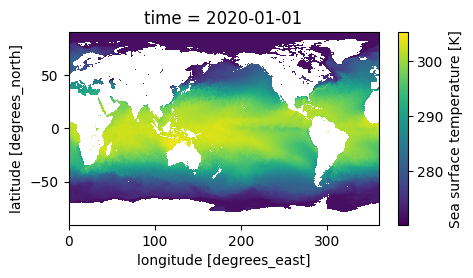

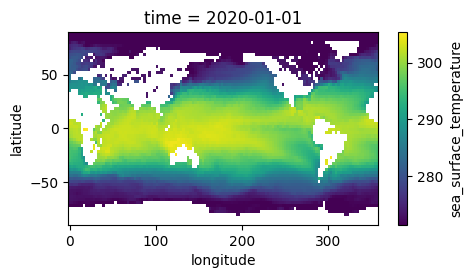

In [30]:
sliced_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

However, we still have missing values (NaN) in the locations shown in white over land. We'll fill those with values from the nearest non-missing locations:

In [31]:
regridded_and_filled = xarray_utils.fill_nan_with_nearest(regridded)

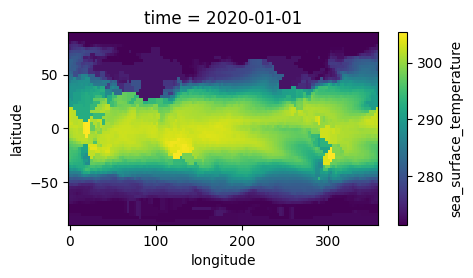

In [32]:
regridded_and_filled.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

Now we have a dataset ready for feeding into NeuralGCM!

## Converting to/from Xarray

NeuralGCM's {ref}`learned-methods` transform data in the form of dictionaries of NumPy or JAX arrays:

- Expected dict keys for `inputs` and `forcings` are indicated by `model.input_variables` and `model.forcing_variables`.
- Dictionary values should be arrays with shape `(level, longitude, latitude)` or `(time, level, longitude, latitude)`, depending upon whether the function expects or produces outputs with a time axis. The `level` axis is size 1 for surface variables (i.e., sea surface temperature and sea ice concentration).
- In addition to surface and 3D fields, a `sim_time` variable is used to calculate incident solar radiation. Unlike the other vairables, `sim_time` needs to be provided already converted into the model's internal non-dimensional units (JAX does not support NumPy's `datetime64` dtype).

{py:meth}`~neuralgcm.PressureLevelModel.inputs_from_xarray` and {py:meth}`~neuralgcm.PressureLevelModel.forcings_from_xarray` convert `xarray.Dataset` objects with the appropriate variables into dictionary of array format, either with or without a leading time dimension:

In [60]:
inputs = model.inputs_from_xarray(regridded_and_filled)
forcings = model.forcings_from_xarray(regridded_and_filled)

In [58]:
jax.tree.map(np.shape, inputs)

{'geopotential': (37, 128, 64),
 'sim_time': (),
 'specific_cloud_ice_water_content': (37, 128, 64),
 'specific_cloud_liquid_water_content': (37, 128, 64),
 'specific_humidity': (37, 128, 64),
 'temperature': (37, 128, 64),
 'u_component_of_wind': (37, 128, 64),
 'v_component_of_wind': (37, 128, 64)}

In [61]:
jax.tree.map(np.shape, forcings)

{'sea_ice_cover': (1, 128, 64),
 'sea_surface_temperature': (1, 128, 64),
 'sim_time': ()}

Notice that `sim_time` was calculated automatically. It can also be calculated explicitly from `numpy.datetime64` arrays using {py:meth}`~PressureLevelModel.datetime64_to_simtime`:

In [59]:
inputs['sim_time']

array(188693.6256)

In [64]:
model.datetime64_to_sim_time(regridded_and_filled.time.data)

188693.6256

Outputs from NeuralGCM can be converted back into an `xarray.Dataset` with appropriate coordinates via {py:meth}`~PressureLevelModel.data_to_xarray`. Pass in `times=None` if there is no leading time-axis, or supply a 1D numpy array of time values:

In [65]:
model.data_to_xarray(
    model.inputs_from_xarray(regridded_and_filled),
    times=None,  # times=None indicates no leading time-axis
)

<xarray.Dataset>
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * longitude                            (longitude) float64 0.0 2.812 ... 357.2
  * latitude                             (latitude) float64 -87.86 ... 87.86
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
Data variables:
    u_component_of_wind                  (level, longitude, latitude) float32 ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 ...
    temperature                          (level, longitude, latitude) float32 ...
    v_component_of_wind                  (level, longitude, latitude) float32 ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 ...
    sim_time                             float64 1.887e+05
    geopotential                         (level, longitude, latitude) float32 ...
    specific_humidity                    (level, longitude, latitude) float32 ...
Attributes:
    longitude_wavenumbers:     64
    total_wavenumbers:         65
    longitude_nodes:           128
    latitude_nodes:            64
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

```{tip}
In principle, {py:meth}`~neuralgcm.PressureLevelModel.simtime_to_datetime64` can calculate output times automatically (e.g., from the outputs of {py:meth}`~neuralgcm.PressureLevelModel.unroll`), but this isn't recommended. By default, JAX does math in float32 mode, which can result in significant rounding errors (e.g., up to a few minutes). As illustrated in the {doc}`inference_demo`, we recommend calculating times directly with NumPy or pandas.
```

## Time shifting

In the NeuralGCM paper, we used one other data preparation trick for forcing variables: we shifted them backwards in time (by one day), so we could not be accused of leaking data from the future into our weather forecasts.

This can be reproduced with the `selective_temporal_shift()` utility, which acts lazily even on datasets that do not fit into memory:

In [ ]:
xarray_utils.selective_temporal_shift(
    dataset=full_era5,
    variables=model.forcing_variables,
    time_shift='24 hours',
)

<xarray.Dataset>
Dimensions:                              (time: 1087680, level: 37,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 90.0 89.75 ... -90.0
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float32 0.0 0.25 ... 359.8
  * time                                 (time) datetime64[ns] 1900-01-02 ......
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 ...
    specific_humidity                    (time, level, latitude, longitude) float32 ...
    temperature                          (time, level, latitude, longitude) float32 ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 ...
    sea_ice_cover                        (time, latitude, longitude) float32 ...
    sea_surface_temperature              (time, latitude, longitude) float32 ...